# Mobile games


Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

- В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
- Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
- Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [51]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import pingouin as pg
from datetime import datetime
from scipy.stats import norm
import scipy.stats as ss
import statsmodels.api as sm
from tqdm.auto import tqdm

### Retention function
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

Посмотрим на структуру данных:

In [2]:
#данные о времени регистрации

reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-bobodzhanova/shared/problem1-reg_data.csv', sep = ';')
reg_data.head() 

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
# данные о времени захода пользователей в игру

auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-bobodzhanova/shared/problem1-auth_data.csv', sep = ';')
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [4]:
reg_data.shape

(1000000, 2)

In [5]:
auth_data.shape

(9601013, 2)

In [6]:
reg_data.isnull().sum() # нет пропусков в данных

reg_ts    0
uid       0
dtype: int64

In [7]:
auth_data.isnull().sum() # нет пропусков в данных

auth_ts    0
uid        0
dtype: int64

In [8]:
reg_data.duplicated().sum() # нет дубликатов записей

0

In [9]:
auth_data.duplicated().sum() # нет дубликатов записей

0

В датафреймах данные о времени зафиксированы в формате Unix, переведем их в обычный формат

In [10]:
reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts,unit='s').dt.floor('D')
auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts,unit='s').dt.floor('D')
reg_data.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [11]:
auth_data.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


Перед тем как написать функцию Retention посмотрим за какой период у нас есть данные:


In [12]:
print(f'Данные о регистрации представлены за период с {reg_data.reg_ts.min()} по {reg_data.reg_ts.max()} ')
print(f'Данные о заходе пользователей в игру представлены с {auth_data.auth_ts.min()} по {auth_data.auth_ts.max()} ')

Данные о регистрации представлены за период с 1998-11-18 00:00:00 по 2020-09-23 00:00:00 
Данные о заходе пользователей в игру представлены с 1998-11-18 00:00:00 по 2020-09-23 00:00:00 


In [13]:
# Функция retention принимает на вход 4 аргумента:
# auth_path - путь к файлу с данными о времени захода пользователей в игру
# reg_path - путь к файлу с данными о времени регистрации пользователей в игру
# start_date - начальная дата исследуемого периода
# final_date - конечная дата исследуемого периода
# и выводит тепловую карту со значениями RR за исследуюемый период по когортам

def retention(auth_path, reg_path, start_date, final_date):    
  
    # считываем датафрейм со времнем входа по пути файла
    auth_data = pd.read_csv(auth_path, sep=';')
    
    # считываем датафрейм с регистрацией по пути файла
    reg_data = pd.read_csv(reg_path, sep=';') 

    # переводим Unix timestamp формат даты регистрации во временной
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date
    
    # переводим строку в формат даты
    start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    final_date = datetime.strptime(final_date, '%Y-%m-%d').date()    
  
    # выбираем в датафрейме регистрации временной промежуток, который больше старотовой даты
    reg_data = reg_data.query('reg_ts > @start_date')
    
    # выбираем в датафрейме авторизации временной промежуток, который меньше конечной даты
    auth_data = auth_data.query('auth_ts <= @final_date')
    
    data = auth_data.merge(reg_data, on='uid', how="inner") # соединяем два файла по uid

    # считаем временную разницу в днях для даты авторизации и регистрации
    data['date_diff'] = (data['auth_ts'] - data['reg_ts']).dt.days
   
    
    # формируем сводную таблицу для отслеживания retention rate
    data_pivot = data.pivot_table(index='reg_ts', columns='date_diff', values='uid', aggfunc='nunique')
    
    # записываем данные 0-го дня в отдельную переменную
    zero_day = data_pivot.iloc[:, 0]
    
    # формируем таблицу для подсчета Retention
    retention_table = data_pivot.divide(zero_day, axis=0)
    
    # строим тепловую карту для визуализации Retention игроков
    plt.figure(figsize=(20, 15))
    plt.title('Retention rate игроков c {} по {}'.format(start_date, final_date), fontsize=20)
    sns.heatmap(retention_table, vmin=0.0, vmax=0.1,
                linewidths=1, fmt='.2%', annot=True)
    plt.ylabel('Дата регистрации', fontsize=15) 
    plt.xlabel('Количество дней посещения игры с момента регистрации', fontsize=15)
    plt.show()    
    

Тестируем функцию и выведем тепловую карту по retantion rate с 2020-09-01 по 2020-09-20. 

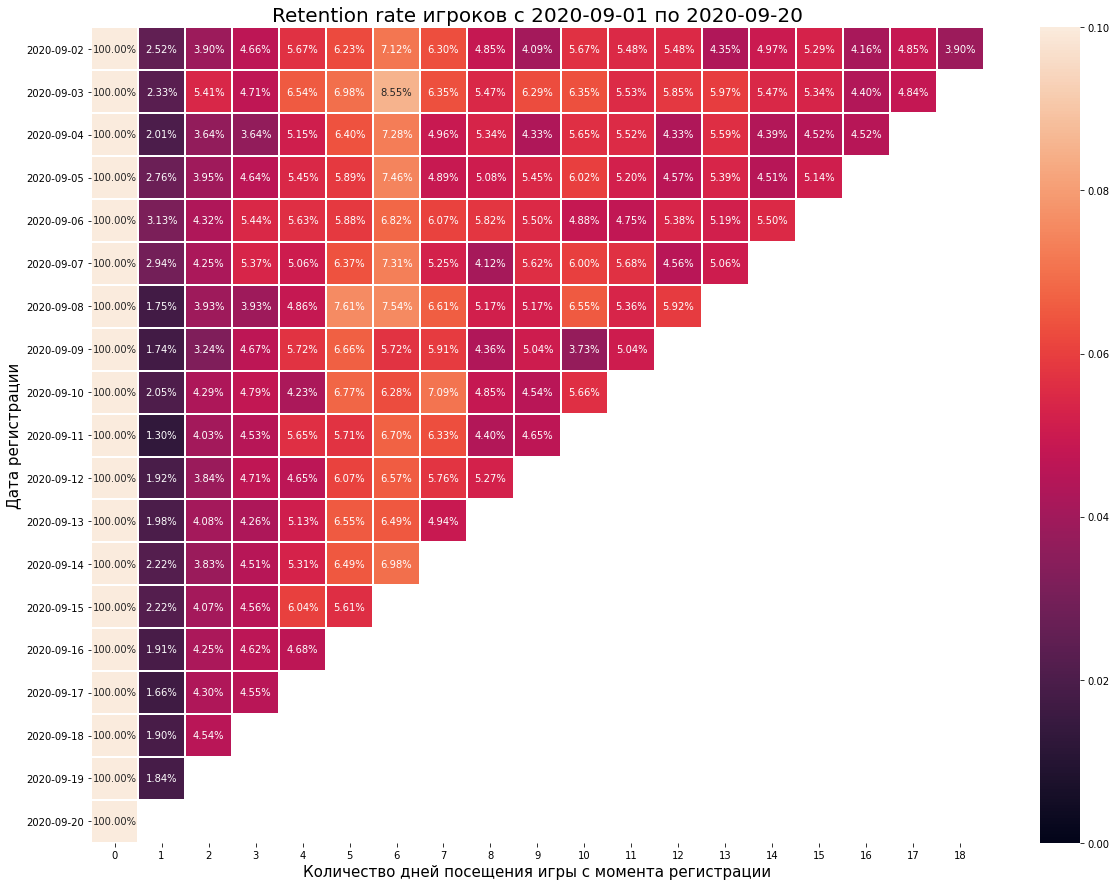

In [14]:
auth_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-bobodzhanova/shared/problem1-auth_data.csv'
reg_path = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-bobodzhanova/shared/problem1-reg_data.csv'
retention(auth_path, reg_path, '2020-09-01', '2020-09-20')

### A/B test

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Для начала посмотрим на данные:

In [15]:
df = pd.read_csv('task2.csv', sep = ';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [16]:
df.shape #всего 404770 наблюдений

(404770, 3)

In [17]:
df.isnull().sum() #нет пропущенных значений

user_id      0
revenue      0
testgroup    0
dtype: int64

In [18]:
df.user_id.nunique() #дуюликаты user_id отсутсвуют

404770

Посмотрим на распрделение выручки среди платящих пользователей в контрольной и тестовой группе

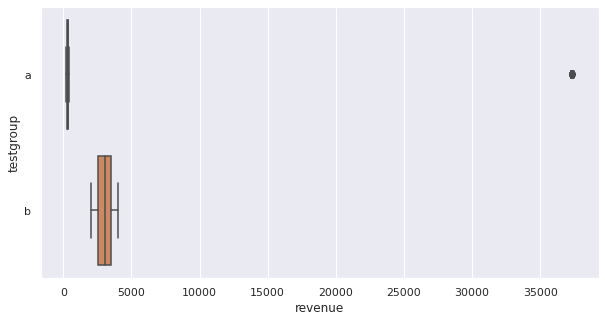

In [24]:
sns.set(rc={'figure.figsize': (10, 5)})
sns.boxplot(data = df.query('revenue > 0'), x = "revenue", y = "testgroup")

В контрольной группе есть значительные выбросы в данных, в тестовой группе выбросы отсутсвуют.


In [25]:
df.query('testgroup == "a" and revenue > 0').revenue.quantile([0.05, 0.25, 0.5, 0.75, 0.90, 0.95])

0.05      211.00
0.25      257.00
0.50      311.00
0.75      361.00
0.90      393.30
0.95    37299.65
Name: revenue, dtype: float64

In [26]:
df.query('testgroup == "b" and revenue > 0').revenue.quantile([0.05, 0.25, 0.5, 0.75, 0.90, 0.95])

0.05    2094.0
0.25    2513.0
0.50    3022.0
0.75    3478.0
0.90    3795.8
0.95    3891.8
Name: revenue, dtype: float64

Распределение прибыли от платящих пользователей в тестовой группе более равномерное, в контрольной группе примерно 5% пользователей принесли доход выше 35000.

Для принятия прравильного решения по выбору акционного предложения посмотрим на метрики **ARPU**, **ARPPU**, а также конверсию **CR** в платящего пользователя для каждой из групп.

In [27]:
df['paying_user'] = df.revenue.apply(lambda x: 1 if x > 0 else 0) #создадим новуб колонку для обозначения платящих пользователей

In [28]:
df.head()

,user_id,revenue,testgroup,paying_user
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


In [29]:
df_res = df \
    .groupby('testgroup', as_index = False) \
    .agg({'user_id':'count', 
          'revenue': 'sum', 
          'paying_user' : 'sum'}) \
    .rename(columns = {'user_id' : 'total_number_of_users', 
                       'paying_user' : 'number_of_paying_users'})
df_res

,testgroup,total_number_of_users,revenue,number_of_paying_users
0,a,202103,5136189,1928
1,b,202667,5421603,1805


In [30]:
df_res['ARPU'] = df_res.revenue / df_res.total_number_of_users
df_res['ARPPU'] = df_res.revenue / df_res.number_of_paying_users
df_res['CR'] = df_res.number_of_paying_users / df_res.total_number_of_users * 100
df_res

,testgroup,total_number_of_users,revenue,number_of_paying_users,ARPU,ARPPU,CR
0,a,202103,5136189,1928,25.413720,2663.998444,0.953969
1,b,202667,5421603,1805,26.751287,3003.658172,0.890624


In [31]:
print('ARPU в тестовой группе выше на {} %'.format(round((df_res.query('testgroup == "b"').ARPU[1] / df_res.query('testgroup == "a"').ARPU[0] - 1) * 100)))


ARPU в тестовой группе выше на 5 %


In [32]:
print('ARPPU в тестовой группе выше на {} %'.format(round((df_res.query('testgroup == "b"').ARPPU[1] / df_res.query('testgroup == "a"').ARPPU[0] - 1) * 100)))


ARPPU в тестовой группе выше на 13 %


Разделим данные на тестовую и контрольную группу и посмотрим выполняются ли предпосылки от нормальности распрделения данных и гомогенности дисперсий.
Для этого разделим данные на две выборки - тестовая и контрольная группа.

In [33]:
control = df.query('testgroup == "a"')
test = df.query('testgroup == "b"')

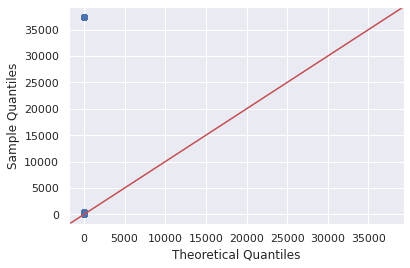

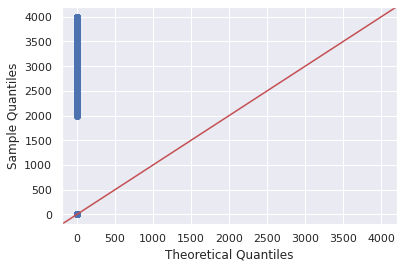

In [36]:
fig = sm.qqplot(control.revenue, line='45')
plt.show()
fig = sm.qqplot(test.revenue, line='45')
plt.show()

По распрделению QQ-plot видно, что распрделения в тестовой и контрольных группах отличаются от нормального. Проверим это с помощью стат.теста Харке-Бера.

In [39]:
pg.normality(data = df, dv = "revenue", group = "testgroup", method = "normaltest")

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Тест на нормальность тоже показал, что данные в двух группах распрделены не нормально.
Проверим гомогенность дисперсий в двух выборках с помощью теста Левена.

In [40]:
ss.levene(control.revenue, test.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Тест Левена показывает, что в дисперсии в двух группах не различаются (p-value > 0.05)

Итак, вводные по нашим данным в контрольной и тестовой группе:

- Величины репрезентативны, независимы и случайны. Гарантировать этого нельзя, так как данные были предосталвены на веру, поэтому будем считать, что это так
- Распределение в двух группах отличаются от нормального
- Дисперсии в двух группах гамогенны
- Объем выборок большой (примерно 200тыс.), при этом объем выборок в тестовой и контрольной группе примерно одинаковы
- В контрольной группе имеются большие выбросы в данных. Так как природа возникновения и способ формирования выборки нам неизвестны, поэтому избавиться от них мы не можем.

Исходя их характеристики данных, наиболее целесообразно использовать метод Bootstrap для сравнения средних значений Revenue в контрольной и тестовых группах.

С помощью Bootstrap проверим следующие гипотезы, для проверки разницы между **ARPU**:

H0 - среднее значение выручки в тестовой группы не отличается от среднего значения в контрольной группе

Н1 - среднее значение выручки в тестовой группы отличается от среднего значения в контрольной группе


In [53]:
def get_bootstrap(
    bootstrap_control,  # числовые значения первой выборки
    bootstrap_test,     # числовые значения второй выборки
    boot_it=1000,       # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = bootstrap_control.sample(
            len(bootstrap_control), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = bootstrap_test.sample(
            len(bootstrap_test), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

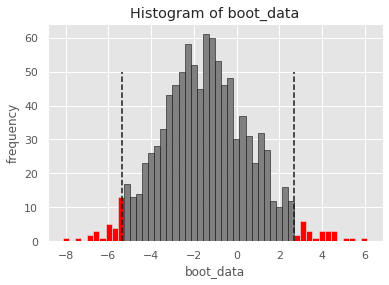

In [55]:
booted_data = get_bootstrap(control.revenue, test.revenue)

In [56]:
booted_data['p_value']

0.4903819011356588

Bootstrap анализ показал p-value > 0.05 и значение 0 попадает в доверительный интервал, что означает то что гипотеза H1 о присутсвии стат.значимого различия между ARPU в тестовой и контрольной группе **отклоняется**.

Проверим есть ли различия между **ARPPU** в тестовой и контрольной группе.

In [60]:
control_pay = df.query('testgroup == "a" and paying_user == 1')
test_pay = df.query('testgroup == "b" and paying_user == 1')

Проверим данные на нормальность распрделения и гомогенность дисперсий.

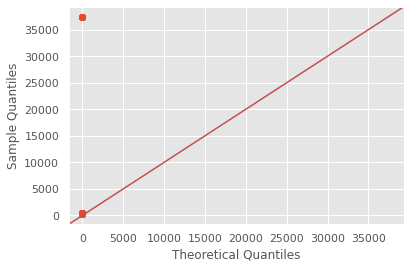

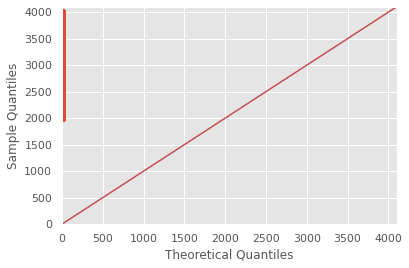

In [61]:
fig = sm.qqplot(control_pay.revenue, line='45')
plt.show()
fig = sm.qqplot(test_pay.revenue, line='45')
plt.show()

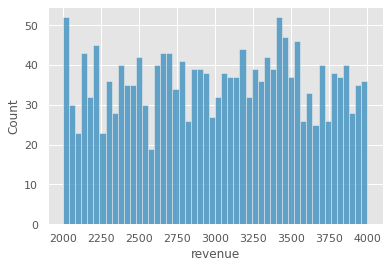

In [62]:
sns.histplot(test_pay.revenue, bins=50)

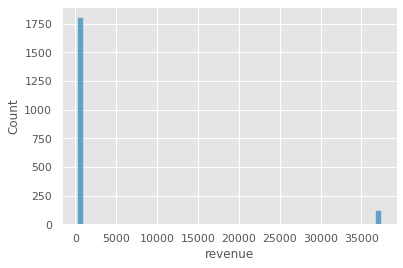

In [63]:
sns.histplot(control_pay.revenue, bins=50)

В тестовой группе распрделение выручки более равномерное, в контрольной есть значительные выбросы и данные сконуентрированы на точке вокруг 0. Однако, в обоих случаях по графику QQ видно, что распрделение отличается от нормального.
Проверим это с помощью стат. теста. Так как выборки не такие большие <5000 используем для этого критейрий согласия Колмогорова.

In [65]:
ss.kstest(control_pay.revenue, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [66]:
ss.kstest(test_pay.revenue, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

В обоих случаях критерий Колмогорова имеет p-value < 0.05, что показвает, что и тестовая и контрольная выборки не принадлежат нормальному распрделению

Проверим гомогенность дисперсий в двух группах с помощью теста Левена.

In [68]:
ss.levene(control_pay.revenue, test_pay.revenue)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Тест Левена показывает, что гомогенность дисперсий не соблюдается (p-value < 0.05). Ияходя из полученных данных для сравнения ARPPU снова будем использовать метод Bootstrap. Будем проверять следующие гипотезы:

H0 - среднее значение выручки  от платящих пользователей в тестовой группы не отличается от среднего значения в контрольной группе

Н1 - среднее значение выручки от платящих пользователей в тестовой группы отличается от среднего значения в контрольной группе

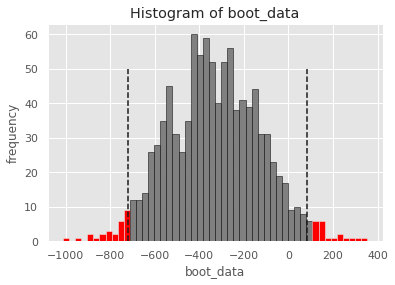

In [70]:
booted_data = get_bootstrap(control_pay.revenue, test_pay.revenue)

In [71]:
booted_data['p_value']

0.10815651550374476

Bootstrap анализ показал p-value > 0.05 и нулевое значение попало в доверительный интервал, что значит ARPPU в тестовой и контрольной группах не отличаются.

Также, проверим есть ли статюзначимые различия между **Conversion Rate**, для этого будем импользовать критерий хи-квадрат для сравнения категориальных переменных (paying_user 1 либо 0). Будем проверять следующие гипотезы:

Н0 – конверсия в переход в платящего пользователя в тестовой и контрольной группе  не различаются.

Н1 – конверсия в переход в платящего пользователя в тестовой и контрольной группе различаются.

In [76]:
statistics, pvalue = ss.chi2_contingency(pd.crosstab(df.testgroup, df.paying_user))[::2]

In [77]:
statistics, pvalue

(4.374729521260405, 1)

В данном случае также, p-value > 0.05, что означает CR в двух группах не различаются стат.значимо. 

### Metrics

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Метрики при обычной механике:

1. **DAU, WAU** -  сколько игроков приняли участие в событии и начали проходить уровни в день/неделю.


2. **Конверсия участников** - какой процент участников завершили все уровни и получили награду. Если показатель слишком низкий, стоил задуматься о сложности уровней игры, также и в обратном случае если слишком большая конверсия может стоит усложнить уровни. 


3. **Average Session Duration** - средняя длительность сессии каждого игрока во время ивента. Сколько в среднем длится сессия игрока. Если уровни легкие это мотивирует игроков проходить несколько уровней за раз и дольше проводить время в игре. Если же уровни слишком сложные и не получается пройти их за первые попытки это демотивирует игроков. 


4. **ARPU** - стоит оценить увеличился ли средняя выручка от пользователя во время ивента. Если в игре показывается реклама и есть внутренние покупки, нужно оценить какой доход мы получили от ивента.


5. **Retention** - оценить retention по дням, сколько процентов игроков остаются каждый день в игре во время ивента. Помогает оценить насколько игрокам было интересно участвовать, насколько были привлекательны призы во время ивента. 

Дополнительные метрики при усложененной механике:

6. **Среднее количество откатов на уровни** -  сколько раз в среднем игроки откатывались на несколько уровней назад перед успешным завершением события.


7. **Процент отказов** - какой процент игроков не смогли завершить событие из-за частых откатов на уровни. Поможет оценить сколько процентов игроков мы потеряли во время ивента из-за усложненной механики прохождения.


8. **Уровни, которые чаще всего не проходят с первого раза** - поможет оследить есть зи взаимосвязь с потерей игроков с ивента.


9. **Уровни, которые игроки чаще всего не проходят несколько раз подряд** - Такие уровни демотивируют игроков, в таком случае важно оценить насколько редкие и уникальные предметы предлагаются игроку для прохождения, чтобы не терять игроков с ивента.


10. **Среднее количество откатов, после которого игрок перестаёт проходить ивент** - Плможет оценить  после скольких неудачных попытках игроки бросают играть. С точки зрения привлекательности для игроков откаты на несколько уровней может демотивировать. Возможно стоит пересмотреть механику прохождения уровней, возможно откат на один уровень, либо счетчики жизней с таймерами, чтобы меньше игроков отказывались от прохождения ивента.
